# **Recognition of Phlebology Diseases Based on Photographs**

# Dataset


##source: http://isyslab.info/CVI/CVI-img-datasets.zip

# **Using bag of visual words & clustering**

## Import data

In [ ]:
!pip install opencv-python==4.5.5.64

     |████████████████████████████████| 60.5 MB 113 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!python --version

Python 3.7.13


In [ ]:
from glob import glob
import numpy as np
import os
import shutil
import cv2 as cv2
import matplotlib.pyplot as plt
import math
from collections import namedtuple
from tqdm.auto import tqdm as tq
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from pprint import pprint
import seaborn as sns
from sklearn.metrics import classification_report
sns.set()

from skimage.io import imread
from skimage.color import rgb2grey
from sklearn.feature_extraction import image
from sklearn.cluster import KMeans
from skimage.filters import rank, threshold_otsu
from skimage.morphology import closing, square, disk
from skimage import exposure as hist, data, img_as_float
from skimage.segmentation import chan_vese
from skimage.feature import canny
from skimage.color import rgb2gray
from scipy import ndimage as ndi 

In [ ]:
cv2.__version__

'4.5.5'

In [ ]:
#importing dataset from github

In [ ]:
!apt install subversion

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1
Suggested packages:
  db5.3-util libapache2-mod-svn subversion-tools
The following NEW packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 subversion
0 upgraded, 5 newly installed, 0 to remove and 39 not upgraded.
Need to get 2,237 kB of archives.
After this operation, 9,910 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libapr1 amd64 1.6.3-2 [90.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libaprutil1 amd64 1.6.1-2 [84.4 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libserf-1-1 amd64 1.3.9-6 [44.4 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libsvn1 amd64 1.9.7-4ubuntu1 [1,183 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic/universe amd64 subversion amd64 1.9.7-4ubuntu1 

In [ ]:
!svn checkout https://github.com/ishitharaj/phlebologyprojectHSE/trunk/data/

A    data/CVI-img-datasets
A    data/CVI-img-datasets/filtered
A    data/CVI-img-datasets/filtered/1
A    data/CVI-img-datasets/filtered/1/gentle_0.jpg
A    data/CVI-img-datasets/filtered/1/gentle_1.jpg
A    data/CVI-img-datasets/filtered/1/gentle_10.jpg
A    data/CVI-img-datasets/filtered/1/gentle_11.jpg
A    data/CVI-img-datasets/filtered/1/gentle_12.jpg
A    data/CVI-img-datasets/filtered/1/gentle_13.jpg
A    data/CVI-img-datasets/filtered/1/gentle_14.jpg
A    data/CVI-img-datasets/filtered/1/gentle_15.jpg
A    data/CVI-img-datasets/filtered/1/gentle_16.jpg
A    data/CVI-img-datasets/filtered/1/gentle_17.jpg
A    data/CVI-img-datasets/filtered/1/gentle_18.jpg
A    data/CVI-img-datasets/filtered/1/gentle_19.jpg
A    data/CVI-img-datasets/filtered/1/gentle_2.jpg
A    data/CVI-img-datasets/filtered/1/gentle_20.jpg
A    data/CVI-img-datasets/filtered/1/gentle_21.jpg
A    data/CVI-img-datasets/filtered/1/gentle_22.jpg
A    data/CVI-img-datasets/filtered/1/gentle_23.jpg
A    data/CVI-img-

In [ ]:
data_filtered = "/content/data/CVI-img-datasets/filtered"
classes = ['1', '2', '3']

In [ ]:
class1images = glob(data_filtered+'/'+'1'+'/'+'*')
class2images = glob(data_filtered+'/'+'2'+'/'+'*')
class3images = glob(data_filtered+'/'+'3'+'/'+'*')

In [ ]:
#train val test split
class_1 = os.listdir(data_filtered+'/1')
class_2 = os.listdir(data_filtered+'/2')
class_3 = os.listdir(data_filtered+'/3')

for i in range(1,4):
    for t in ["train", "test"]:
        !mkdir -p /content/data/CVI-img-datasets/filtered/{t}/{i}/

base_path = data_filtered
for i in range(0, len(class_1)):
  filename = class_1[i]
  if i <= 45:
    shutil.copy(f"{base_path}/1/{filename}", f"{base_path}/train/1/{filename}")
  else:
    shutil.copy(f"{base_path}/1/{filename}", f"{base_path}/test/1/{filename}")

for i in range(0, len(class_2)):
  filename = class_2[i]
  if i <= 43:
    shutil.copy(f"{base_path}/2/{filename}", f"{base_path}/train/2/{filename}")
  else:
    shutil.copy(f"{base_path}/2/{filename}", f"{base_path}/test/2/{filename}")

for i in range(0, len(class_3)):
  filename = class_3[i]
  if i <= 91:
    shutil.copy(f"{base_path}/3/{filename}", f"{base_path}/train/3/{filename}")
  else:
    shutil.copy(f"{base_path}/3/{filename}", f"{base_path}/test/3/{filename}")

In [ ]:
len(class1images), len(class2images), len(class3images)

(59, 57, 105)

In [ ]:
#load image paths
def load_images(paths):
    tmp = []
    for path in paths:
        tmp.append(imread(path))
    return tmp

In [ ]:
#plot images
def plot_any(arr, title = ''):
    plt.figure(figsize = (15, 25))
    for i in range(len(arr)):
        plt.subplot(1,len(arr),i + 1)
        plt.title(title)
        plt.imshow(arr[i]);

In [ ]:
load_class1images = load_images(class1images[:5])
load_class2images = load_images(class2images[:5])
load_class3images = load_images(class3images[:5])

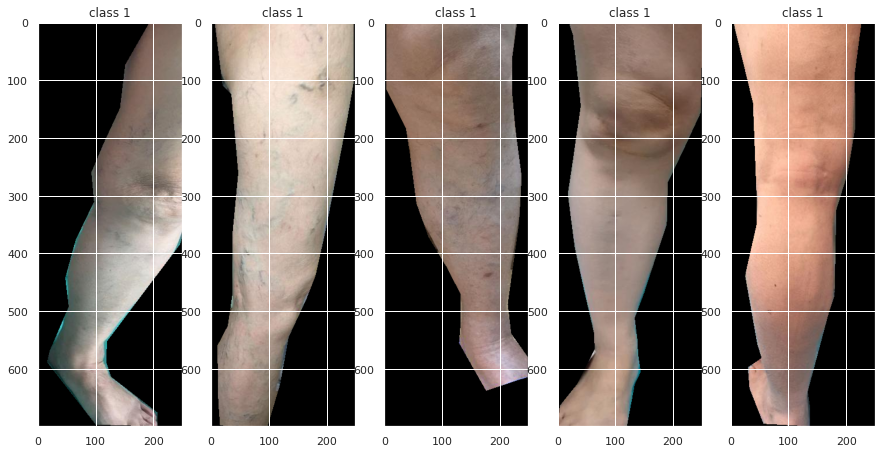

In [ ]:
plot_any(load_class1images, 'class 1')

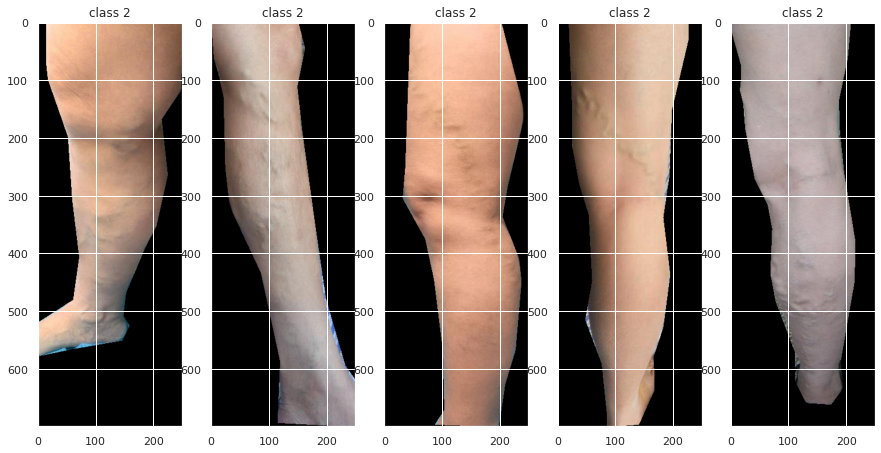

In [ ]:
plot_any(load_class2images, 'class 2')

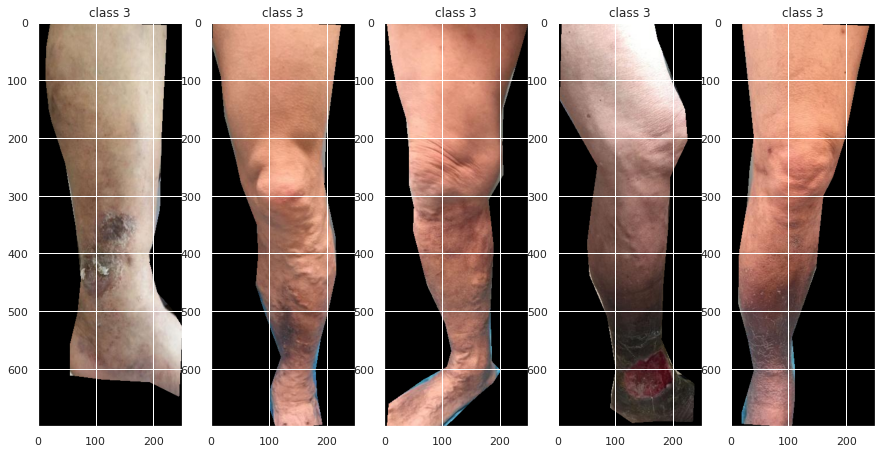

In [ ]:
plot_any(load_class3images, 'class 3')

In [ ]:
CLASSES = ['1', '2', '3']
PATHS = namedtuple('_', ('train', 'test'))('/content/data/CVI-img-datasets/filtered/train', '/content/data/CVI-img-datasets/filtered/test')
SIZE = (148, 148)

Here, we perform a classification task using Bag of Visual Words (BoVW) technique. 

In [ ]:
def show(img, ax=None):
    if not ax:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()
    else:
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        return ax

In [ ]:
def load_test(cls, lim=None):
    path = os.path.join(PATHS.test, cls)
    imgs = os.listdir(path)
    if (lim is not None) and (len(imgs) > lim):
        imgs = imgs[:lim]
    for f in imgs:
        if f.startswith('.'):
            continue
        f_ = os.path.join(path, f)
        img = cv2.imread(f_)
        img = cv2.resize(img, SIZE, interpolation=cv2.INTER_AREA)
        yield f_, img

In [ ]:
def load_train(cls, lim=None):
    path = os.path.join(PATHS.train, cls)
    imgs = os.listdir(path)
    if (lim is not None) and (len(imgs) > lim):
        imgs = imgs[:lim]
    for f in imgs:
        if f.startswith('.'):
            continue
        f_ = os.path.join(path, f)
        img = cv2.imread(f_)
        img = cv2.resize(img, SIZE, interpolation=cv2.INTER_AREA)
        yield f_, img

In [ ]:
def load_test_all(lim=None):
    for cls in CLASSES:
        for path, img in load_test(cls, lim):
            yield cls, path, img

In [ ]:
def load_train_all(lim=None):
    for cls in CLASSES:
        for path, img in load_train(cls, lim):
            yield cls, path, img

# SIFT extraction

In [ ]:
STEP = 4
VOCAB_SIZE = 200
SVM_LAMDA = 10
SVM_ITER = 2000

def dense_sift(img, step=STEP):
    keypoints = []
    for i in range(step//2, img.shape[0], step):
        for j in range(step//2, img.shape[1], step):
            keypoints.append(cv2.KeyPoint(j, i, step))
    
    sift = cv2.SIFT_create()
    return sift.compute(img, keypoints)

In [ ]:
def dense_sift_batch(batch, step=STEP):
    labels = []
    paths = []
    keypoints = []
    descriptors = []
    for cls, path, img in tq(batch):
        labels.append(cls)
        paths.append(path)
        kps, desc = dense_sift(img, step)
        keypoints.append(kps)
        descriptors.append(desc)
    return labels, paths, keypoints, descriptors

# Binning histograms and clustering

In [ ]:
def bin_histograms(labels, descriptors, k):
    
    histograms = np.zeros((len(descriptors), k), dtype=np.float64)
    idx = 0
    for i, desc in enumerate(descriptors):
        for _ in range(desc.shape[0]):
            histograms[i, labels[idx]] += 1
            idx += 1
    return histograms

In [ ]:
def cluster(descriptors, k=VOCAB_SIZE, kmeans=None):
    descriptors_flat = np.concatenate(descriptors)
    
    if kmeans is None:
        kmeans = KMeans(n_clusters=k, n_init=5)
        cluster_labels = kmeans.fit_predict(descriptors_flat)
    else:
        cluster_labels = kmeans.predict(descriptors_flat)
        k = kmeans.cluster_centers_.shape[0]
    
    histograms = bin_histograms(cluster_labels, descriptors, k)
            
    return kmeans, histograms

#TF-IDF

In [ ]:
class TFIDF:
    def __init__(self):
        self.log_weights = None
    def normalise(self, histograms):
        if self.log_weights is None:
            weights = np.count_nonzero(histograms, axis=0) + 1
            self.log_weights = np.log(histograms.shape[0] / weights)
            
        return histograms * self.log_weights

# Train classifier

In [ ]:
def train_classifier(histograms, labels, num_iter=SVM_ITER, lamda=SVM_LAMDA):
    labels = np.array(labels, dtype='object')
    svm = LinearSVC(C=lamda, max_iter=num_iter, dual=(histograms.shape[0]<=histograms.shape[1])).fit(histograms, labels)
    return svm

In [ ]:
tr_labels, _, tr_keypoints, tr_descriptors = dense_sift_batch(load_train_all())
kmeans, tr_histograms = cluster(tr_descriptors)
tfidf = TFIDF()
tr_norm_histograms = tfidf.normalise(tr_histograms)
classifier = train_classifier(tr_norm_histograms, tr_labels)

0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [ ]:
te_labels, te_paths, _, te_descriptors = dense_sift_batch(load_test_all())
_, te_histograms = cluster(te_descriptors, kmeans=kmeans)
te_norm_histograms = tfidf.normalise(te_histograms)
te_labels_pred = classifier.predict(te_norm_histograms)
tr_labels_pred = classifier.predict(tr_norm_histograms)

0it [00:00, ?it/s]

In [ ]:
def confusion(actual, predicted, classes):
    conf = np.zeros((len(classes), len(classes)), dtype=np.float64)
    
    mp = {}
    for i, cls in enumerate(classes):
        mp[cls] = i
    
    for a, p in zip(actual, predicted):
        conf[mp[a], mp[p]] += 1
    return conf / conf.sum(axis=1, keepdims=True)

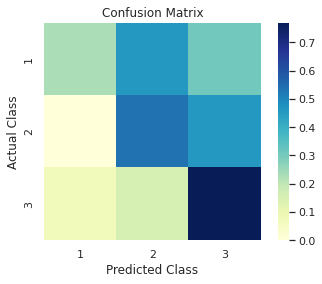

In [ ]:
conf = confusion(te_labels, te_labels_pred, CLASSES)
ax = sns.heatmap(conf, cmap='YlGnBu', xticklabels=CLASSES, yticklabels=CLASSES, square=True)
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')
ax.set_title('Confusion Matrix')
plt.show()

In [ ]:
NUM_PLOT = 10

tr_labels = np.array(tr_labels, dtype='object')
tr_good_ind = np.where(np.equal(tr_labels, tr_labels_pred))[0]

acc = len(tr_good_ind) * 100 / len(tr_labels)
print(f'Train Accuracy: {acc}%')

te_labels = np.array(te_labels, dtype='object')
good_ind = np.where(np.equal(te_labels, te_labels_pred))[0]
bad_ind = np.where(np.not_equal(te_labels, te_labels_pred))[0]

acc = len(good_ind) * 100 / len(te_labels)
print(f'Test Accuracy: {acc}%')

good_ind = np.random.choice(good_ind, size=min(len(good_ind), NUM_PLOT), replace=False)
bad_ind = np.random.choice(bad_ind, size=min(len(bad_ind), NUM_PLOT), replace=False)

Train Accuracy: 99.45054945054945%
Test Accuracy: 51.282051282051285%


In [ ]:
print(classification_report(te_labels, te_labels_pred))

              precision    recall  f1-score   support

           1       0.75      0.23      0.35        13
           2       0.47      0.54      0.50        13
           3       0.50      0.77      0.61        13

    accuracy                           0.51        39
   macro avg       0.57      0.51      0.49        39
weighted avg       0.57      0.51      0.49        39



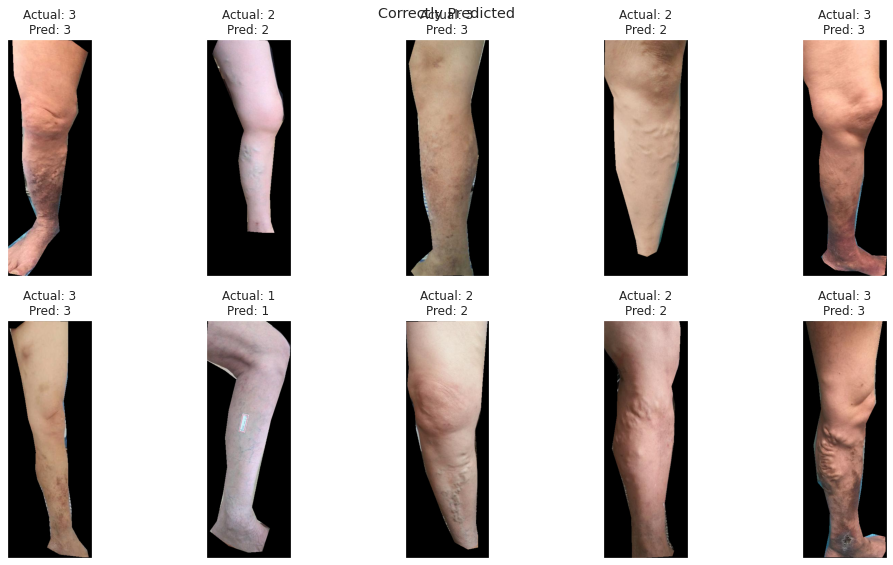

In [ ]:
fig, axs = plt.subplots(2, math.ceil(len(good_ind)/2), figsize=(15, 8))

for i, ax in enumerate(axs.flat):
    if i >= len(good_ind):
        ax.imshow(np.ones((75, 75, 3)))
        ax.axis('off')
        continue
    
    idx = good_ind[i]
    img = cv2.imread(te_paths[idx])
    ax = show(img, ax)
    ax.set_title(f'Actual: {te_labels[idx]}\nPred: {te_labels_pred[idx]}')
    ax.set_xticks([], minor=[])
    ax.set_yticks([], minor=[])

fig.suptitle('Correctly Predicted')
fig.tight_layout()
plt.show()

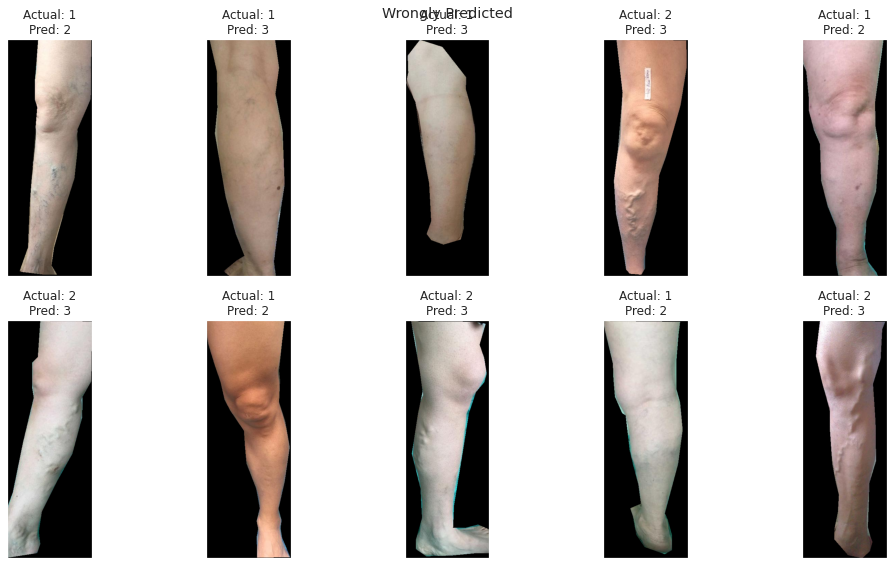

In [ ]:
fig, axs = plt.subplots(2, math.ceil(len(bad_ind)/2), figsize=(15, 8))

for i, ax in enumerate(axs.flat):
    if i >= len(bad_ind):
        ax.imshow(np.ones((75, 75, 3)))
        ax.axis('off')
        continue
    
    idx = bad_ind[i]
    img = cv2.imread(te_paths[idx])
    ax = show(img, ax)
    ax.set_title(f'Actual: {te_labels[idx]}\nPred: {te_labels_pred[idx]}')
    ax.set_xticks([], minor=[])
    ax.set_yticks([], minor=[])

fig.suptitle('Wrongly Predicted')
fig.tight_layout()
plt.show()

#TEST Experiment: Spatial Pyramid

In [ ]:
LEVEL_WEIGHTS = [0.25, 0.25, 0.5]

def blockshaped(arr, nrows, ncols):
    h, w = arr.shape
    assert h % nrows == 0, "{} rows is not evenly divisble by {}".format(h, nrows)
    assert w % ncols == 0, "{} cols is not evenly divisble by {}".format(w, ncols)
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

def histograms_pyramid(keypoints, descriptors, cluster_labels, image_shape=SIZE, level_weights=LEVEL_WEIGHTS, k=VOCAB_SIZE):
    keypoint_positions = np.full(image_shape[:2], -1)
    for i, kp in enumerate(keypoints[0]):
        keypoint_positions[int(kp.pt[0]), int(kp.pt[1])] = i
    
    histograms = np.empty((len(descriptors), 0), dtype=np.float64)
    labels_list = []
    idx = 0
    for i, d in enumerate(descriptors):
        labels_list.append(cluster_labels[idx:idx+d.shape[0]])
        idx += d.shape[0]
    
    for i, w in enumerate(level_weights):
        sz_r = image_shape[0] // (2**i)
        sz_c = image_shape[1] // (2**i)
        blocks = blockshaped(keypoint_positions, sz_r, sz_c)
        blocks = [np.ravel(blocks[i, :, :]) for i in range(blocks.shape[0])]
        blocks = [b[b != -1] for b in blocks]
        for b in blocks:
            sel_desc = [d[b, :] for d in descriptors]
            sel_lab = [l[b] for l in labels_list]
            
            hist = w * bin_histograms(np.concatenate(sel_lab), sel_desc, k)
            histograms = np.hstack((histograms, hist))
            
    return histograms    

def cluster_pyramid(keypoints, descriptors, image_shape=SIZE, k=VOCAB_SIZE, level_weights=LEVEL_WEIGHTS, kmeans=None):
    descriptors_flat = np.concatenate(descriptors)
    
    if kmeans is None:
        kmeans = KMeans(n_clusters=k)
        cluster_labels = kmeans.fit_predict(descriptors_flat)
    else:
        cluster_labels = kmeans.predict(descriptors_flat)
        k = kmeans.cluster_centers_.shape[0]
    
    histograms = histograms_pyramid(keypoints, descriptors, cluster_labels, image_shape, level_weights, k)
            
    return kmeans, histograms

In [ ]:
kmeans, tr_histograms = cluster_pyramid(tr_keypoints, tr_descriptors, kmeans=kmeans)
tfidf = TFIDF()
tr_norm_histograms = tfidf.normalise(tr_histograms)
classifier = train_classifier(tr_norm_histograms, tr_labels)

In [ ]:
te_labels, te_paths, te_keypoints, te_descriptors = dense_sift_batch(load_test_all())
_, te_histograms = cluster_pyramid(te_keypoints, te_descriptors, kmeans=kmeans)
te_norm_histograms = tfidf.normalise(te_histograms)
te_labels_pred = classifier.predict(te_norm_histograms)
tr_labels_pred = classifier.predict(tr_norm_histograms)

0it [00:00, ?it/s]

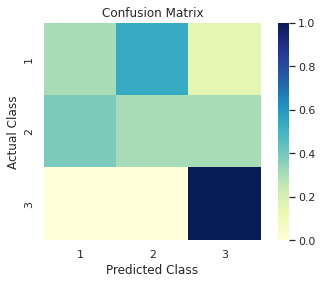

In [ ]:
conf = confusion(te_labels, te_labels_pred, CLASSES)
ax = sns.heatmap(conf, cmap='YlGnBu', xticklabels=CLASSES, yticklabels=CLASSES, square=True)
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')
ax.set_title('Confusion Matrix')
plt.show()

In [ ]:
tr_labels = np.array(tr_labels, dtype='object')
tr_good_ind = np.where(np.equal(tr_labels, tr_labels_pred))[0]

acc = len(tr_good_ind) * 100 / len(tr_labels)
print(f'Train Accuracy: {acc}%')

te_labels = np.array(te_labels, dtype='object')
good_ind = np.where(np.equal(te_labels, te_labels_pred))[0]

acc = len(good_ind) * 100 / len(te_labels)
print(f'Test Accuracy: {acc}%')


Train Accuracy: 100.0%
Test Accuracy: 53.84615384615385%


In [ ]:
print(classification_report(te_labels, te_labels_pred))

              precision    recall  f1-score   support

           1       0.44      0.31      0.36        13
           2       0.36      0.31      0.33        13
           3       0.68      1.00      0.81        13

    accuracy                           0.54        39
   macro avg       0.50      0.54      0.50        39
weighted avg       0.50      0.54      0.50        39



#Without TF/IDF

0it [00:00, ?it/s]

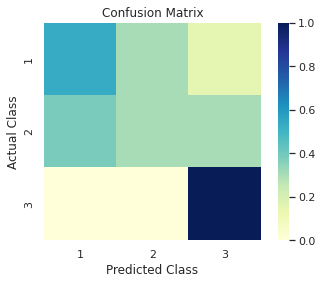

Train Accuracy: 100.0%
Test Accuracy: 61.53846153846154%


In [ ]:
classifier = train_classifier(tr_histograms, tr_labels)
te_labels, te_paths, te_keypoints, te_descriptors = dense_sift_batch(load_test_all())
_, te_histograms = cluster_pyramid(te_keypoints, te_descriptors, kmeans=kmeans)
te_labels_pred = classifier.predict(te_histograms)
tr_labels_pred = classifier.predict(tr_histograms)

conf = confusion(te_labels, te_labels_pred, CLASSES)
ax = sns.heatmap(conf, cmap='YlGnBu', xticklabels=CLASSES, yticklabels=CLASSES, square=True)
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')
ax.set_title('Confusion Matrix')
plt.show()

tr_labels = np.array(tr_labels, dtype='object')
tr_good_ind = np.where(np.equal(tr_labels, tr_labels_pred))[0]

acc = len(tr_good_ind) * 100 / len(tr_labels)
print(f'Train Accuracy: {acc}%')

te_labels = np.array(te_labels, dtype='object')
good_ind = np.where(np.equal(te_labels, te_labels_pred))[0]

acc = len(good_ind) * 100 / len(te_labels)
print(f'Test Accuracy: {acc}%')

In [ ]:
print(classification_report(te_labels, te_labels_pred))

              precision    recall  f1-score   support

           1       0.58      0.54      0.56        13
           2       0.50      0.31      0.38        13
           3       0.68      1.00      0.81        13

    accuracy                           0.62        39
   macro avg       0.59      0.62      0.58        39
weighted avg       0.59      0.62      0.58        39

